# 3D Scene-Aware Canvas Placement Prototype

This notebook demonstrates a simplified approach to placing 3D scene-aware canvases on video frames using depth maps.

## Overview

The prototype consists of 4 main steps:
1. **Frame Extraction** - Extract frames from input video
2. **Camera Intrinsics Estimation** - Estimate camera parameters using OpenCV
3. **Depth Estimation** - Generate depth maps using Video-Depth-Anything
4. **Interactive Canvas Placement** - Place canvases by clicking on frames

Each step includes visual verification and testing.


In [ ]:
from pathlib import Path
vda_path = Path("Video-Depth-Anything")
print(f"Video-Depth-Anything found: {vda_path.exists()}")

Video-Depth-Anything found: True


In [ ]:
# Setup & Imports
import os
import sys
import json
import shutil
import time
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import Button
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm import tqdm
from PIL import Image

# Set up paths
OUTPUT_DIR = "outputs"
FRAMES_DIR = os.path.join(OUTPUT_DIR, "frames")
DEPTH_DIR = os.path.join(OUTPUT_DIR, "depth")
CANVAS_DATA_FILE = os.path.join(OUTPUT_DIR, "canvas_data.json")

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(DEPTH_DIR, exist_ok=True)

print("✓ Imports successful")
print(f"Output directory: {OUTPUT_DIR}")


✓ Imports successful
Output directory: outputs


## Step 1: Frame Extraction

Extract frames from the input video and save them for processing.


In [ ]:
def extract_frames(video_path, output_dir, max_resolution=None):
    """
    Extract frames from video and save them as images.
    
    Args:
        video_path: Path to input video file
        output_dir: Directory to save extracted frames
        max_resolution: Optional (max_width, max_height) to resize large videos
        
    Returns:
        frame_count: Number of frames extracted
        fps: Frames per second
        resolution: (width, height) tuple (after resizing if applicable)
    """
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    original_resolution = (width, height)
    
    # Resize if needed (for very large videos like 4K)
    if max_resolution is not None:
        max_w, max_h = max_resolution
        if width > max_w or height > max_h:
            scale = min(max_w / width, max_h / height)
            width = int(width * scale)
            height = int(height * scale)
            print(f"  Resizing frames from {original_resolution[0]}x{original_resolution[1]} to {width}x{height}")
    
    print(f"Video properties:")
    print(f"  Original resolution: {original_resolution[0]}x{original_resolution[1]}")
    print(f"  Output resolution: {width}x{height}")
    print(f"  FPS: {fps:.2f}")
    print(f"  Total frames: {total_frames}")
    
    # Extract frames
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize if needed
        if max_resolution is not None and (frame.shape[1] != width or frame.shape[0] != height):
            frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        
        # Save frame (use JPEG with quality 95 for good quality/size balance)
        frame_filename = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_JPEG_QUALITY, 95])
        frame_count += 1
        
        if frame_count % 10 == 0:
            print(f"  Extracted {frame_count} frames...", end='\r')
    
    cap.release()
    print(f"\n✓ Extracted {frame_count} frames to {output_dir}")
    
    return frame_count, fps, (width, height)

# Example usage (uncomment and set your video path):
# VIDEO_PATH = "4511004-uhd_3840_2160_24fps_rgb_src.mp4"
# # For 4K videos, you may want to resize to 1920x1080 for faster processing
# frame_count, fps, resolution = extract_frames(VIDEO_PATH, FRAMES_DIR, max_resolution=(1920, 1080))


In [ ]:
# Visualize extracted frames
def visualize_frames(frames_dir, num_frames=6):
    """Display a grid of extracted frames."""
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    if len(frame_files) == 0:
        print("No frames found in directory")
        return
    
    num_display = min(num_frames, len(frame_files))
    cols = 3
    rows = (num_display + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(num_display):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        frame_path = os.path.join(frames_dir, frame_files[idx])
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {idx}: {frame_files[idx]}")
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(num_display, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize:
# visualize_frames(FRAMES_DIR)


### Step 1 Testing: Frame Extraction Verification


In [ ]:
def test_frame_extraction(frames_dir, expected_count, video_resolution):
    """Test frame extraction results."""
    import os
    import cv2
    
    # Check directory exists
    assert os.path.exists(frames_dir), "Frames directory not found"
    
    # Count frames
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    assert len(frame_files) == expected_count, \
        f"Expected {expected_count} frames, got {len(frame_files)}"
    
    # Check first frame dimensions
    first_frame_path = os.path.join(frames_dir, frame_files[0])
    first_frame = cv2.imread(first_frame_path)
    assert first_frame is not None, f"Failed to read {frame_files[0]}"
    assert first_frame.shape[:2] == video_resolution[::-1], \
        f"Frame resolution mismatch: {first_frame.shape[:2]} vs {video_resolution[::-1]}"
    
    # Verify frames are readable
    for frame_file in frame_files[:5]:  # Test first 5
        img = cv2.imread(os.path.join(frames_dir, frame_file))
        assert img is not None, f"Failed to read {frame_file}"
        assert img.size > 0, f"Empty frame: {frame_file}"
        assert img.shape[2] == 3, f"Expected 3 channels, got {img.shape[2]}"
    
    print("✓ Frame extraction test passed")
    print(f"  Extracted {len(frame_files)} frames")
    print(f"  Resolution: {first_frame.shape[1]}x{first_frame.shape[0]}")
    return True

# Uncomment to test:
# test_frame_extraction(FRAMES_DIR, frame_count, resolution)


## Step 2: Camera Intrinsics Estimation

Estimate camera intrinsics matrix using OpenCV. We'll try chessboard calibration first, then fall back to default estimation.


In [ ]:
def estimate_camera_intrinsics(frames_dir, video_resolution, chessboard_size=(9, 6)):
    """
    Estimate camera intrinsics matrix.
    
    Args:
        frames_dir: Directory containing frames
        video_resolution: (width, height) tuple
        chessboard_size: (cols, rows) for chessboard calibration (optional)
        
    Returns:
        K: 3x3 camera intrinsics matrix
    """
    width, height = video_resolution
    
    # Try chessboard calibration first
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    
    # Prepare object points
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    
    # Find chessboard corners in frames
    found_count = 0
    for frame_file in frame_files[:20]:  # Check first 20 frames
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            found_count += 1
    
    # If we found enough chessboard patterns, calibrate
    if found_count >= 3:
        print(f"Found chessboard patterns in {found_count} frames. Calibrating...")
        ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, (width, height), None, None
        )
        print("✓ Camera calibration successful")
        return K
    
    # Fall back to default estimation
    print("No chessboard patterns found. Using default intrinsics estimation...")
    fx = fy = width * 1.2  # Common for phone cameras
    cx, cy = width / 2, height / 2
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]], dtype=np.float64)
    
    print("✓ Using default camera intrinsics")
    print(f"  Focal length: fx={fx:.1f}, fy={fy:.1f}")
    print(f"  Principal point: ({cx:.1f}, {cy:.1f})")
    
    return K

# Example usage:
# K = estimate_camera_intrinsics(FRAMES_DIR, resolution)


In [ ]:
# Visualize camera intrinsics
def visualize_camera_intrinsics(K, video_resolution):
    """Display camera intrinsics matrix and FOV."""
    width, height = video_resolution
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    # Calculate FOV
    fov_x = 2 * np.arctan(width / (2 * fx)) * 180 / np.pi
    fov_y = 2 * np.arctan(height / (2 * fy)) * 180 / np.pi
    
    print("Camera Intrinsics Matrix (K):")
    print(K)
    print(f"\nCamera Parameters:")
    print(f"  Focal length: fx={fx:.2f}, fy={fy:.2f}")
    print(f"  Principal point: cx={cx:.2f}, cy={cy:.2f}")
    print(f"  Field of view: {fov_x:.1f}° x {fov_y:.1f}°")
    
    # Visualize matrix
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('tight')
    ax.axis('off')
    table_data = [
        [f"{K[0,0]:.2f}", f"{K[0,1]:.2f}", f"{K[0,2]:.2f}"],
        [f"{K[1,0]:.2f}", f"{K[1,1]:.2f}", f"{K[1,2]:.2f}"],
        [f"{K[2,0]:.2f}", f"{K[2,1]:.2f}", f"{K[2,2]:.2f}"]
    ]
    table = ax.table(cellText=table_data, 
                     colLabels=['fx/0/cx', '0/fy/cy', '0/0/1'],
                     rowLabels=['Row 1', 'Row 2', 'Row 3'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    plt.title("Camera Intrinsics Matrix", fontsize=14, fontweight='bold')
    plt.show()

# Uncomment to visualize:
# visualize_camera_intrinsics(K, resolution)


### Step 2 Testing: Camera Intrinsics Verification


In [ ]:
def test_camera_intrinsics(K, video_resolution):
    """Test camera intrinsics matrix."""
    import numpy as np
    
    # Check shape
    assert K.shape == (3, 3), f"Expected 3x3 matrix, got {K.shape}"
    
    # Check properties
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    assert fx > 0 and fy > 0, "Focal lengths must be positive"
    assert 0 < cx < video_resolution[0], \
        f"Principal point x ({cx}) out of bounds [0, {video_resolution[0]}]"
    assert 0 < cy < video_resolution[1], \
        f"Principal point y ({cy}) out of bounds [0, {video_resolution[1]}]"
    
    # Check invertibility
    condition_number = np.linalg.cond(K)
    assert condition_number < 1e10, \
        f"Matrix is ill-conditioned (condition number: {condition_number})"
    
    # Test projection (3D to 2D)
    test_point_3d = np.array([1.0, 1.0, 5.0])  # 3D point
    projected = K @ test_point_3d
    assert projected[2] > 0, "Projection failed (negative Z)"
    
    # Test back-projection (2D to 3D with known depth)
    test_x, test_y = 100, 100
    test_depth = 5.0
    X = (test_x - cx) * test_depth / fx
    Y = (test_y - cy) * test_depth / fy
    assert np.isfinite(X) and np.isfinite(Y), "Back-projection produced invalid values"
    
    print("✓ Camera intrinsics test passed")
    print(f"  Focal lengths: fx={fx:.1f}, fy={fy:.1f}")
    print(f"  Principal point: ({cx:.1f}, {cy:.1f})")
    print(f"  Condition number: {condition_number:.2e}")
    return True


### Fix xformers Compatibility Issue (if needed)

If you encounter the error `cannot import name '_CAFFE2_ATEN_FALLBACK'`, this is a compatibility issue between xformers and PyTorch. 

**Quick Fix:** Run the cell below to uninstall xformers (the model works without it, just slower):


In [ ]:
# Uncomment and run this cell if you get xformers compatibility errors
# !pip uninstall xformers -y
# Then restart the kernel (Kernel -> Restart Kernel) and run the cells again


## Step 3: Video-Depth-Anything Depth Estimation

Generate depth maps for each frame using Video-Depth-Anything model.


In [ ]:
def setup_video_depth_anything(model_path=None, encoder='vits'):
    """
    Setup Video-Depth-Anything model.
    
    Args:
        model_path: Path to model checkpoint (if None, will try to load from default location)
        encoder: Model size ('vits', 'vitb', or 'vitl')
        
    Returns:
        (model, device) tuple or None if setup fails
    """
    import torch
    import sys
    from pathlib import Path
    
    # Add Video-Depth-Anything to path
    vda_path = Path("Video-Depth-Anything")
    if not vda_path.exists():
        print("Warning: Video-Depth-Anything directory not found.")
        print("Please clone it: git clone https://github.com/DepthAnything/Video-Depth-Anything")
        return None
    
    sys.path.insert(0, str(vda_path))
    
    try:
        # Handle xformers/PyTorch compatibility issues
        import warnings
        import types
        
        # IMPORTANT: Patch torch.utils.serialization BEFORE any imports
        # This module was removed in PyTorch 2.0+ but xformers still tries to import it
        if not hasattr(torch.utils, 'serialization'):
            # Create a dummy serialization module
            serialization_module = types.ModuleType('serialization')
            # Add dummy attributes that xformers might try to access
            serialization_module.read_lua_file = lambda *args, **kwargs: None
            serialization_module.load_lua = lambda *args, **kwargs: None
            
            # Create a dummy config object that xformers might try to import
            # xformers does: from serialization import config
            config_obj = types.ModuleType('config')
            # Add any attributes config might need (return None for any attribute access)
            config_obj.__getattr__ = lambda name: None
            serialization_module.config = config_obj
            
            # Attach to torch.utils
            torch.utils.serialization = serialization_module
            # Add to sys.modules so 'from torch.utils import serialization' works
            # Also handle 'import torch.utils.serialization' and 'from serialization import config'
            sys.modules['torch.utils.serialization'] = serialization_module
            sys.modules['serialization'] = serialization_module  # For direct 'from serialization import config'
            # Make sure torch.utils is in sys.modules too
            if 'torch.utils' not in sys.modules:
                sys.modules['torch.utils'] = torch.utils
        
        # Patch torch.autocast globally to handle CPU devices
        # This must be done before importing Video-Depth-Anything
        original_autocast = torch.autocast
        def patched_autocast(device_type=None, enabled=True, **kwargs):
            # Always return no-op for CPU devices (autocast doesn't support CPU in some PyTorch versions)
            # Check both string 'cpu' and any device object that represents CPU
            if device_type == 'cpu' or str(device_type) == 'cpu':
                from contextlib import nullcontext
                return nullcontext()
            # For non-CPU devices, use original autocast
            try:
                return original_autocast(device_type=device_type, enabled=enabled, **kwargs)
            except RuntimeError as e:
                # If autocast fails for any reason, return no-op context manager
                if 'unsupported autocast device_type' in str(e):
                    from contextlib import nullcontext
                    return nullcontext()
                raise
        torch.autocast = patched_autocast
        
        # Suppress warnings during import
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            # Try importing Video-Depth-Anything
            try:
                from video_depth_anything.video_depth import VideoDepthAnything
            except (ImportError, AttributeError, RuntimeError, ModuleNotFoundError) as import_err:
                error_msg = str(import_err)
                # Check for various compatibility issues
                if '_CAFFE2_ATEN_FALLBACK' in error_msg or 'serialization' in error_msg:
                    print("=" * 70)
                    print("⚠ XFORMERS/PYTORCH COMPATIBILITY ERROR DETECTED")
                    print("=" * 70)
                    print(f"\nError: {error_msg}")
                    print("\nThis error occurs because xformers is incompatible with your PyTorch version.")
                    print("Video-Depth-Anything can work WITHOUT xformers (just slower).")
                    print("\n🔧 SOLUTION:")
                    print("1. Run this command in a terminal (or uncomment the cell above):")
                    print("   pip uninstall xformers -y")
                    print("\n2. Restart the Jupyter kernel:")
                    print("   Kernel -> Restart Kernel")
                    print("\n3. Run the cells again.")
                    print("\nAlternatively, you can install compatible versions:")
                    print("   pip install torch==2.1.1 torchvision==0.16.1 xformers==0.0.23")
                    print("=" * 70)
                    print("\nReturning None - depth estimation will be skipped.")
                    print("You can still test the notebook with dummy depth maps.")
                    return None
                else:
                    # Re-raise if it's a different error
                    raise import_err
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        # Model configurations (from Video-Depth-Anything run.py)
        model_configs = {
            'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
            'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
            'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        }
        
        if encoder not in model_configs:
            print(f"Invalid encoder: {encoder}. Must be one of: {list(model_configs.keys())}")
            return None
        
        # Load model checkpoint path
        if model_path is None:
            checkpoint_dir = vda_path / "checkpoints"
            checkpoint_name = f"video_depth_anything_{encoder}.pth"
            model_path = checkpoint_dir / checkpoint_name
        
        if not os.path.exists(model_path):
            print(f"Model checkpoint not found at {model_path}")
            print("Please download model weights first (see setup_instructions.md)")
            return None
        
        # Initialize model with correct config
        model = VideoDepthAnything(**model_configs[encoder], metric=False)
        
        # Load weights (checkpoint is a state dict, not a dict with keys)
        checkpoint = torch.load(model_path, map_location='cpu')
        model.load_state_dict(checkpoint, strict=True)
        
        model.to(device)
        model.eval()
        
        print(f"✓ Model loaded successfully: {encoder}")
        return model, device
        
    except ImportError as e:
        print(f"Failed to import Video-Depth-Anything: {e}")
        print("Please ensure Video-Depth-Anything is properly installed")
        print("See setup_instructions.md for installation steps")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please check the model path and Video-Depth-Anything installation")
        import traceback
        traceback.print_exc()
        return None

# Example usage:
# model, device = setup_video_depth_anything(encoder='vits')


In [ ]:
def estimate_depth_video(model, device, frames_dir, output_dir, max_frames=None, target_fps=24, input_size=518):
    """
    Estimate depth maps for all frames using Video-Depth-Anything.
    
    Args:
        model: Video-Depth-Anything model
        device: torch device
        frames_dir: Directory containing frames
        output_dir: Directory to save depth maps
        max_frames: Maximum number of frames to process (None for all)
        target_fps: Target FPS for video (used by model)
        input_size: Input size for model (default 518)
        
    Returns:
        depth_maps: List of depth map file paths
        depth_range: (min_depth, max_depth) tuple
        depth_offset: Depth offset value
    """
    import torch
    import cv2
    
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    if max_frames:
        frame_files = frame_files[:max_frames]
    
    print(f"Loading {len(frame_files)} frames...")
    
    # Load all frames as numpy array (shape: [N, H, W, 3] in RGB format)
    # This matches the format expected by Video-Depth-Anything
    frames_list = []
    for frame_file in tqdm(frame_files, desc="Loading frames"):
        frame_path = os.path.join(frames_dir, frame_file)
        # Load as RGB (Video-Depth-Anything expects RGB)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Failed to load {frame_file}")
            continue
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames_list.append(frame_rgb)
    
    if len(frames_list) == 0:
        print("Error: No frames loaded")
        return [], (0, 0), 0
    
    # Convert to numpy array: [N, H, W, 3]
    frames_array = np.stack(frames_list, axis=0)
    print(f"Frames shape: {frames_array.shape}")
    
    # Use Video-Depth-Anything's infer_video_depth method
    # This processes the entire video sequence at once for temporal consistency
    print(f"Estimating depth for {len(frames_array)} frames...")
    print("This may take a while for long videos...")
    
    try:
        # Use fp32=True for CPU to avoid autocast issues (autocast doesn't support CPU)
        # For CUDA, fp32=False enables mixed precision for faster inference
        use_fp32 = (str(device) == 'cpu')
        
        # Note: torch.autocast is already patched in setup_video_depth_anything to handle CPU
        depths_array, fps = model.infer_video_depth(
            frames_array, 
            target_fps=target_fps,
            input_size=input_size,
            device=device,
            fp32=use_fp32
        )
        
        # depths_array shape: [N, H, W]
        print(f"Depth maps shape: {depths_array.shape}")
        
        # Save individual depth maps
        depth_maps = []
        all_depths = []
        
        for idx in range(len(depths_array)):
            depth = depths_array[idx]
            
            # Save depth map
            depth_filename = os.path.join(output_dir, f"depth_{idx:04d}.npy")
            np.save(depth_filename, depth)
            depth_maps.append(depth_filename)
            all_depths.append(depth)
        
        # Calculate depth range and offset
        all_depths_array = np.concatenate([d.flatten() for d in all_depths])
        depth_min = np.min(all_depths_array)
        depth_max = np.max(all_depths_array)
        depth_range = (depth_min, depth_max)
        depth_offset = depth_min
        
        print(f"✓ Depth estimation complete")
        print(f"  Processed {len(depth_maps)} frames")
        print(f"  Depth range: [{depth_min:.4f}, {depth_max:.4f}]")
        print(f"  Depth mean: {np.mean(all_depths_array):.4f}, std: {np.std(all_depths_array):.4f}")
        
        return depth_maps, depth_range, depth_offset
        
    except Exception as e:
        print(f"Error during depth estimation: {e}")
        import traceback
        traceback.print_exc()
        return [], (0, 0), 0

# Example usage:
# depth_maps, depth_range, depth_offset = estimate_depth_video(model, device, FRAMES_DIR, DEPTH_DIR)


In [ ]:
# Visualize depth maps
def visualize_depth(frames_dir, depth_dir, frame_idx=0):
    """Display original frame and corresponding depth map side by side."""
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    depth_files = sorted([f for f in os.listdir(depth_dir) 
                         if f.endswith('.npy')])
    
    if frame_idx >= len(frame_files) or frame_idx >= len(depth_files):
        print(f"Frame index {frame_idx} out of range")
        return
    
    # Load frame
    frame_path = os.path.join(frames_dir, frame_files[frame_idx])
    frame = cv2.imread(frame_path)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Load depth
    depth_path = os.path.join(depth_dir, depth_files[frame_idx])
    depth = np.load(depth_path)
    
    # Normalize depth for visualization
    depth_normalized = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    depth_colored = plt.cm.viridis(depth_normalized)[:, :, :3]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(frame_rgb)
    axes[0].set_title(f"Original Frame {frame_idx}", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(depth_colored)
    axes[1].set_title(f"Depth Map {frame_idx}", fontsize=14)
    axes[1].axis('off')
    
    # Depth histogram
    axes[2].hist(depth.flatten(), bins=50, color='blue', alpha=0.7)
    axes[2].set_title("Depth Histogram", fontsize=14)
    axes[2].set_xlabel("Depth Value")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Depth Statistics for Frame {frame_idx}:")
    print(f"  Min: {depth.min():.4f}")
    print(f"  Max: {depth.max():.4f}")
    print(f"  Mean: {depth.mean():.4f}")
    print(f"  Std: {depth.std():.4f}")

# Uncomment to visualize:
# visualize_depth(FRAMES_DIR, DEPTH_DIR, frame_idx=0)


### Step 3 Testing: Depth Estimation Verification


In [ ]:
def test_depth_estimation(depth_dir, frames_dir, num_frames):
    """Test depth estimation results."""
    import os
    import cv2
    import numpy as np
    
    # Check depth maps exist
    depth_files = sorted([f for f in os.listdir(depth_dir) 
                         if f.endswith(('.png', '.npy'))])
    assert len(depth_files) == num_frames, \
        f"Expected {num_frames} depth maps, got {len(depth_files)}"
    
    # Check first frame dimensions
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    
    first_depth_path = os.path.join(depth_dir, depth_files[0])
    if depth_files[0].endswith('.npy'):
        first_depth = np.load(first_depth_path)
    else:
        first_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
        if first_depth.ndim == 3:
            first_depth = first_depth[:, :, 0]
    
    assert first_depth.shape[:2] == first_frame.shape[:2], \
        f"Depth map dimensions {first_depth.shape[:2]} don't match frame {first_frame.shape[:2]}"
    
    # Validate depth values
    assert np.all(first_depth >= 0), "Negative depth values found"
    assert np.any(first_depth > 0), "All depth values are zero"
    assert np.all(np.isfinite(first_depth)), "Depth map contains NaN or Inf values"
    
    # Check depth range
    depth_min, depth_max = np.min(first_depth), np.max(first_depth)
    assert depth_max > depth_min, "Depth map has no variation"
    assert depth_max < 1e6, f"Unreasonably large depth values (max: {depth_max})"
    
    # Temporal consistency (check depth doesn't change drastically)
    if len(depth_files) > 1:
        depth1_path = os.path.join(depth_dir, depth_files[0])
        depth2_path = os.path.join(depth_dir, depth_files[1])
        
        if depth_files[0].endswith('.npy'):
            depth1 = np.load(depth1_path)
            depth2 = np.load(depth2_path)
        else:
            depth1 = cv2.imread(depth1_path, cv2.IMREAD_UNCHANGED)
            depth2 = cv2.imread(depth2_path, cv2.IMREAD_UNCHANGED)
            if depth1.ndim == 3:
                depth1 = depth1[:, :, 0]
            if depth2.ndim == 3:
                depth2 = depth2[:, :, 0]
        
        mean_diff = np.mean(np.abs(depth1.astype(float) - depth2.astype(float)))
        print(f"  Mean depth difference between frames: {mean_diff:.2f}")
    
    print("✓ Depth estimation test passed")
    print(f"  Depth range: [{depth_min:.2f}, {depth_max:.2f}]")
    print(f"  Depth mean: {np.mean(first_depth):.2f}, std: {np.std(first_depth):.2f}")
    return True

# Uncomment to test:
# test_depth_estimation(DEPTH_DIR, FRAMES_DIR, frame_count)


## Step 4: Interactive Canvas Placement UI

Place canvases by clicking on frames. The canvas will be scene-aware using depth information.


In [ ]:
# Utility functions for canvas placement

def unproject_2d_to_3d(x, y, depth, K):
    """Convert 2D pixel + depth to 3D position."""
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    X = (x - cx) * depth / fx
    Y = (y - cy) * depth / fy
    Z = depth
    
    return np.array([X, Y, Z])

def project_3d_to_2d(X, Y, Z, K):
    """Project 3D position to 2D pixel coordinates."""
    point_3d = np.array([X, Y, Z])
    point_2d_homogeneous = K @ point_3d
    point_2d = point_2d_homogeneous[:2] / point_2d_homogeneous[2]
    return point_2d[0], point_2d[1]

def draw_canvas_overlay(frame, canvas_pos_2d, canvas_size, depth_map, canvas_depth):
    """
    Draw canvas overlay on frame with occlusion handling.
    
    Args:
        frame: RGB frame (numpy array, shape: HxWx3)
        canvas_pos_2d: (x, y) position in pixels
        canvas_size: (width, height) of canvas
        depth_map: Depth map (numpy array, shape: HxW)
        canvas_depth: Depth value at canvas position
        
    Returns:
        Frame with canvas overlay drawn
    """
    frame_with_canvas = frame.copy()
    x, y = int(canvas_pos_2d[0]), int(canvas_pos_2d[1])
    w, h = canvas_size
    
    # Validate coordinates
    if x < 0 or x >= frame.shape[1] or y < 0 or y >= frame.shape[0]:
        return frame_with_canvas
    
    # Create bounding box
    x1 = max(0, x - w // 2)
    y1 = max(0, y - h // 2)
    x2 = min(frame.shape[1], x + w // 2)
    y2 = min(frame.shape[0], y + h // 2)
    
    # Check occlusion: canvas visible where scene depth > canvas depth
    if y2 > y1 and x2 > x1:
        bbox_depth = depth_map[y1:y2, x1:x2]
        if bbox_depth.size > 0:
            visible_mask = bbox_depth > canvas_depth
            visible_ratio = np.sum(visible_mask) / visible_mask.size
            
            # Draw bounding box (BGR color for OpenCV)
            # Green if mostly visible, orange if mostly occluded
            color_bgr = (0, 255, 0) if visible_ratio > 0.5 else (0, 165, 255)  # BGR format
            cv2.rectangle(frame_with_canvas, (x1, y1), (x2, y2), color_bgr, 2)
            
            # Draw crosshair at placement point (green)
            crosshair_size = max(10, min(frame.shape[0], frame.shape[1]) // 50)
            cv2.line(frame_with_canvas, 
                    (max(0, x - crosshair_size), y), 
                    (min(frame.shape[1], x + crosshair_size), y), 
                    (0, 255, 0), 2)
            cv2.line(frame_with_canvas, 
                    (x, max(0, y - crosshair_size)), 
                    (x, min(frame.shape[0], y + crosshair_size)), 
                    (0, 255, 0), 2)
            
            # Draw semi-transparent overlay
            overlay = frame_with_canvas.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color_bgr, -1)
            cv2.addWeighted(overlay, 0.2, frame_with_canvas, 0.8, 0, frame_with_canvas)
    
    return frame_with_canvas


In [ ]:
def create_interactive_ui(frames_dir, depth_dir, camera_K, video_resolution, display_scale=1.0):
    """
    Create interactive UI for canvas placement.
    
    Args:
        frames_dir: Directory containing frames
        depth_dir: Directory containing depth maps
        camera_K: Camera intrinsics matrix
        video_resolution: (width, height) tuple
        display_scale: Scale factor for display (1.0 = full size, 0.5 = half size)
    """
    
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    depth_files = sorted([f for f in os.listdir(depth_dir) 
                         if f.endswith('.npy')])
    
    if len(frame_files) != len(depth_files):
        print(f"Warning: Frame count ({len(frame_files)}) != Depth count ({len(depth_files)})")
        min_count = min(len(frame_files), len(depth_files))
        frame_files = frame_files[:min_count]
        depth_files = depth_files[:min_count]
    
    # Canvas data storage
    canvas_data = {
        'frame_idx': None,
        'position_2d': None,
        'position_3d': None,
        'depth': None,
        'size': (100, 100)  # Default canvas size
    }
    
    # Create widgets
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(frame_files) - 1,
        step=1,
        description='Frame:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )
    
    canvas_size_slider = widgets.IntSlider(
        value=100,
        min=50,
        max=300,
        step=10,
        description='Canvas Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )
    
    clear_button = widgets.Button(description='Clear Canvas', button_style='danger')
    save_button = widgets.Button(description='Save Canvas', button_style='success')
    
    output = widgets.Output()
    
    # Store click handler reference
    click_handler = None
    
    def update_display(frame_idx):
        """Update the display with current frame and canvas."""
        nonlocal click_handler
        
        with output:
            clear_output(wait=True)
            
            # Load frame and depth on demand (memory efficient)
            frame_path = os.path.join(frames_dir, frame_files[frame_idx])
            depth_path = os.path.join(depth_dir, depth_files[frame_idx])
            
            frame = cv2.imread(frame_path)
            depth_map = np.load(depth_path)
            
            if frame is None:
                print(f"Failed to load frame {frame_idx}")
                return
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            original_shape = frame_rgb.shape
            
            # Resize for display if needed (for large videos)
            display_frame = frame_rgb.copy()
            display_depth = depth_map.copy()
            if display_scale < 1.0:
                display_w = int(frame_rgb.shape[1] * display_scale)
                display_h = int(frame_rgb.shape[0] * display_scale)
                display_frame = cv2.resize(frame_rgb, (display_w, display_h), interpolation=cv2.INTER_AREA)
                display_depth = cv2.resize(depth_map, (display_w, display_h), interpolation=cv2.INTER_LINEAR)
            
            # Draw canvas if placed
            if canvas_data['position_2d'] is not None and canvas_data['frame_idx'] == frame_idx:
                canvas_pos_2d = canvas_data['position_2d']
                canvas_size = canvas_data['size']
                canvas_depth = canvas_data['depth']
                
                # Scale canvas position for display
                if display_scale < 1.0:
                    display_pos = (int(canvas_pos_2d[0] * display_scale), 
                                  int(canvas_pos_2d[1] * display_scale))
                    display_size = (int(canvas_size[0] * display_scale), 
                                   int(canvas_size[1] * display_scale))
                else:
                    display_pos = canvas_pos_2d
                    display_size = canvas_size
                
                display_frame = draw_canvas_overlay(
                    display_frame, display_pos, display_size, display_depth, canvas_depth
                )
            
            # Create visualization
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            
            axes[0].imshow(display_frame)
            axes[0].set_title(f"Frame {frame_idx} - Click to place canvas", fontsize=14)
            axes[0].axis('off')
            
            # Depth visualization
            depth_normalized = (display_depth - display_depth.min()) / (display_depth.max() - display_depth.min() + 1e-8)
            depth_colored = plt.cm.viridis(depth_normalized)
            axes[1].imshow(depth_colored)
            axes[1].set_title("Depth Map", fontsize=14)
            axes[1].axis('off')
            
            # Remove old click handler if exists
            if click_handler is not None:
                fig.canvas.mpl_disconnect(click_handler)
            
            # Add click handler
            def on_click(event):
                if event.inaxes == axes[0] and event.button == 1:  # Left click
                    if event.xdata is None or event.ydata is None:
                        return
                    
                    # Get click coordinates in display space
                    click_x = int(event.xdata)
                    click_y = int(event.ydata)
                    
                    # Convert to original frame coordinates
                    if display_scale < 1.0:
                        orig_x = int(click_x / display_scale)
                        orig_y = int(click_y / display_scale)
                    else:
                        orig_x = click_x
                        orig_y = click_y
                    
                    # Validate coordinates
                    if 0 <= orig_x < original_shape[1] and 0 <= orig_y < original_shape[0]:
                        # Get depth at original resolution
                        depth = depth_map[orig_y, orig_x]
                        pos_3d = unproject_2d_to_3d(orig_x, orig_y, depth, camera_K)
                        
                        canvas_data['frame_idx'] = frame_idx
                        canvas_data['position_2d'] = (orig_x, orig_y)
                        canvas_data['position_3d'] = pos_3d.tolist()
                        canvas_data['depth'] = float(depth)
                        
                        print(f"Canvas placed at:")
                        print(f"  2D: ({orig_x}, {orig_y})")
                        print(f"  3D: ({pos_3d[0]:.2f}, {pos_3d[1]:.2f}, {pos_3d[2]:.2f})")
                        print(f"  Depth: {depth:.4f}")
                        
                        update_display(frame_idx)
            
            click_handler = fig.canvas.mpl_connect('button_press_event', on_click)
            plt.tight_layout()
            plt.show()
    
    def on_frame_change(change):
        update_display(change['new'])
    
    def on_size_change(change):
        canvas_data['size'] = (change['new'], change['new'])
        if canvas_data['frame_idx'] is not None:
            update_display(canvas_data['frame_idx'])
    
    def on_clear(button):
        canvas_data['frame_idx'] = None
        canvas_data['position_2d'] = None
        canvas_data['position_3d'] = None
        canvas_data['depth'] = None
        update_display(frame_slider.value)
    
    def on_save(button):
        if canvas_data['position_2d'] is not None:
            with open(CANVAS_DATA_FILE, 'w') as f:
                json.dump(canvas_data, f, indent=2)
            print(f"✓ Canvas data saved to {CANVAS_DATA_FILE}")
        else:
            print("No canvas to save")
    
    frame_slider.observe(on_frame_change, names='value')
    canvas_size_slider.observe(on_size_change, names='value')
    clear_button.on_click(on_clear)
    save_button.on_click(on_save)
    
    # Initial display
    update_display(0)
    
    # Display controls
    controls = widgets.VBox([
        frame_slider,
        canvas_size_slider,
        widgets.HBox([clear_button, save_button]),
        output
    ])
    
    return controls, canvas_data

# Example usage:
# For 4K videos, use display_scale=0.5 to show at half resolution for better performance
# ui_controls, canvas_data = create_interactive_ui(FRAMES_DIR, DEPTH_DIR, K, resolution, display_scale=0.5)
# display(ui_controls)


### Step 4 Testing: Canvas Placement Verification


In [ ]:
def test_canvas_placement(canvas_data, depth_maps, camera_K, video_resolution):
    """Test canvas placement data."""
    import numpy as np
    
    required_keys = ['frame_idx', 'position_2d', 'position_3d', 'depth']
    for key in required_keys:
        assert key in canvas_data, f"Missing required key: {key}"
    
    # Validate 2D position
    x, y = canvas_data['position_2d']
    assert 0 <= x < video_resolution[0], \
        f"2D x position {x} out of bounds [0, {video_resolution[0]})"
    assert 0 <= y < video_resolution[1], \
        f"2D y position {y} out of bounds [0, {video_resolution[1]})"
    
    # Validate 3D position
    X, Y, Z = canvas_data['position_3d']
    assert Z > 0, f"3D Z position {Z} must be positive (in front of camera)"
    assert np.all(np.isfinite([X, Y, Z])), "3D position contains invalid values"
    
    # Test 2D to 3D conversion accuracy
    depth = canvas_data['depth']
    fx, fy = camera_K[0, 0], camera_K[1, 1]
    cx, cy = camera_K[0, 2], camera_K[1, 2]
    
    X_test = (x - cx) * depth / fx
    Y_test = (y - cy) * depth / fy
    Z_test = depth
    
    assert np.allclose([X_test, Y_test, Z_test], [X, Y, Z], rtol=1e-3), \
        f"2D to 3D conversion mismatch: expected {[X, Y, Z]}, got {[X_test, Y_test, Z_test]}"
    
    # Test 3D to 2D projection (round-trip)
    point_3d = np.array([X, Y, Z])
    point_2d_homogeneous = camera_K @ point_3d
    point_2d = point_2d_homogeneous[:2] / point_2d_homogeneous[2]
    
    assert np.allclose([point_2d[0], point_2d[1]], [x, y], rtol=1e-2), \
        f"3D to 2D projection mismatch: expected {[x, y]}, got {point_2d}"
    
    # Test occlusion (canvas should be visible where scene depth > canvas depth)
    frame_idx = canvas_data['frame_idx']
    assert 0 <= frame_idx < len(depth_maps), \
        f"Frame index {frame_idx} out of bounds [0, {len(depth_maps)})"
    
    depth_map = depth_maps[frame_idx]
    if isinstance(depth_map, str):
        depth_map = np.load(depth_map)
    
    canvas_depth = depth
    occlusion_mask = depth_map > canvas_depth
    visible_ratio = np.sum(occlusion_mask) / occlusion_mask.size
    
    print(f"  Canvas visibility ratio: {visible_ratio:.2%}")
    print(f"  Canvas 3D position: ({X:.2f}, {Y:.2f}, {Z:.2f})")
    print(f"  Canvas 2D position: ({x}, {y})")
    
    print("✓ Canvas placement test passed")
    return True

# Uncomment to test:
# test_canvas_placement(canvas_data, depth_maps, K, resolution)


## Integration Test: End-to-End Workflow

Run complete workflow and verify all steps work together.


In [ ]:
def integration_test(video_path, test_output_dir, max_resolution=(1920, 1080), max_frames=10):
    """
    Run complete workflow and verify all steps.
    
    Args:
        video_path: Path to test video
        test_output_dir: Directory for test outputs
        max_resolution: Maximum resolution for frame extraction (for large videos)
        max_frames: Maximum frames to process (for faster testing)
    """
    import time
    import os
    import shutil
    
    # Clean test directory
    if os.path.exists(test_output_dir):
        shutil.rmtree(test_output_dir)
    os.makedirs(test_output_dir, exist_ok=True)
    
    test_frames_dir = os.path.join(test_output_dir, "frames")
    test_depth_dir = os.path.join(test_output_dir, "depth")
    
    start_time = time.time()
    
    print("Running integration test...")
    print("=" * 60)
    
    try:
        # Step 1: Frame extraction
        print("\n[1/4] Testing frame extraction...")
        frame_count, fps, resolution = extract_frames(
            video_path, test_frames_dir, max_resolution=max_resolution
        )
        assert frame_count > 0, "No frames extracted"
        
        # Limit frames for testing
        if frame_count > max_frames:
            print(f"  Limiting to first {max_frames} frames for testing...")
            frame_files = sorted([f for f in os.listdir(test_frames_dir) 
                                 if f.endswith(('.png', '.jpg', '.jpeg'))])
            for f in frame_files[max_frames:]:
                os.remove(os.path.join(test_frames_dir, f))
            frame_count = max_frames
        
        test_frame_extraction(test_frames_dir, frame_count, resolution)
        print("  ✓ Frame extraction successful")
        
        # Step 2: Camera intrinsics
        print("\n[2/4] Testing camera intrinsics...")
        K = estimate_camera_intrinsics(test_frames_dir, resolution)
        test_camera_intrinsics(K, resolution)
        print("  ✓ Camera intrinsics estimation successful")
        
        # Step 3: Depth estimation (skip if model not available)
        print("\n[3/4] Testing depth estimation...")
        model_result = setup_video_depth_anything(encoder='vits')
        if model_result is None:
            print("  ⚠ Skipping depth estimation (model not available)")
            print("  Creating dummy depth maps for testing...")
            # Create dummy depth maps
            frame_files = sorted([f for f in os.listdir(test_frames_dir) 
                                 if f.endswith(('.png', '.jpg', '.jpeg'))])
            os.makedirs(test_depth_dir, exist_ok=True)
            depth_maps = []
            for i, frame_file in enumerate(frame_files):
                frame = cv2.imread(os.path.join(test_frames_dir, frame_file))
                # Create dummy depth map (constant depth)
                dummy_depth = np.ones((frame.shape[0], frame.shape[1]), dtype=np.float32) * 5.0
                depth_path = os.path.join(test_depth_dir, f"depth_{i:04d}.npy")
                np.save(depth_path, dummy_depth)
                depth_maps.append(depth_path)
            depth_range = (5.0, 5.0)
            depth_offset = 5.0
        else:
            model, device = model_result
            depth_maps, depth_range, depth_offset = estimate_depth_video(
                model, device, test_frames_dir, test_depth_dir, max_frames=max_frames
            )
        test_depth_estimation(test_depth_dir, test_frames_dir, len(depth_maps))
        print("  ✓ Depth estimation successful")
        
        # Step 4: Canvas placement (simulated)
        print("\n[4/4] Testing canvas placement...")
        test_frame_idx = 0
        test_x, test_y = resolution[0] // 2, resolution[1] // 2
        
        # Get depth at test position
        depth_map = np.load(depth_maps[test_frame_idx]) if isinstance(depth_maps[test_frame_idx], str) else depth_maps[test_frame_idx]
        test_depth = float(depth_map[test_y, test_x])
        
        canvas_data = {
            'frame_idx': test_frame_idx,
            'position_2d': (test_x, test_y),
            'depth': test_depth,
            'position_3d': unproject_2d_to_3d(test_x, test_y, test_depth, K).tolist(),
            'size': (100, 100)
        }
        test_canvas_placement(canvas_data, depth_maps, K, resolution)
        print("  ✓ Canvas placement successful")
        
        elapsed_time = time.time() - start_time
        
        print("\n" + "=" * 60)
        print(f"✓ Integration test PASSED in {elapsed_time:.2f} seconds")
        print("=" * 60)
        
        # Summary
        print("\nTest Summary:")
        print(f"  - Frames extracted: {frame_count}")
        print(f"  - Video resolution: {resolution[0]}x{resolution[1]}")
        print(f"  - Depth maps generated: {len(depth_maps)}")
        print(f"  - Canvas placement: ✓")
        
        return True
        
    except Exception as e:
        print(f"\n✗ Integration test FAILED: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Run integration test with the provided video:
# integration_test("4511004-uhd_3840_2160_24fps_rgb_src.mp4", "test_outputs", max_resolution=(1920, 1080), max_frames=10)


## Export Results

Save canvas data and create augmented frames with canvas overlay.


In [ ]:
def export_canvas_data(canvas_data, output_file):
    """Export canvas data to JSON file."""
    with open(output_file, 'w') as f:
        json.dump(canvas_data, f, indent=2)
    print(f"✓ Canvas data exported to {output_file}")

def create_augmented_frames(frames_dir, depth_dir, canvas_data, output_dir, camera_K):
    """
    Create augmented frames with canvas overlay.
    
    Args:
        frames_dir: Directory containing frames
        depth_dir: Directory containing depth maps
        canvas_data: Canvas placement data dictionary
        output_dir: Directory to save augmented frames
        camera_K: Camera intrinsics matrix (for 3D projection if needed)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = sorted([f for f in os.listdir(frames_dir) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    depth_files = sorted([f for f in os.listdir(depth_dir) 
                         if f.endswith('.npy')])
    
    if canvas_data['position_2d'] is None:
        print("No canvas to render")
        return
    
    canvas_frame_idx = canvas_data['frame_idx']
    canvas_pos_2d = canvas_data['position_2d']
    canvas_size = canvas_data['size']
    canvas_depth = canvas_data['depth']
    
    print(f"Creating augmented frames...")
    for i in tqdm(range(len(frame_files)), desc="Rendering"):
        frame_path = os.path.join(frames_dir, frame_files[i])
        depth_path = os.path.join(depth_dir, depth_files[i])
        
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Failed to load frame {i}")
            continue
            
        depth_map = np.load(depth_path)
        
        # Convert BGR to RGB for drawing function (which expects RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Draw canvas if on this frame
        if i == canvas_frame_idx:
            frame_rgb = draw_canvas_overlay(
                frame_rgb, canvas_pos_2d, canvas_size, depth_map, canvas_depth
            )
        
        # Convert back to BGR for saving with OpenCV
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        
        # Save augmented frame
        output_path = os.path.join(output_dir, f"augmented_{i:04d}.jpg")
        cv2.imwrite(output_path, frame_bgr, [cv2.IMWRITE_JPEG_QUALITY, 95])
    
    print(f"✓ Augmented frames saved to {output_dir}")

# Example usage:
# export_canvas_data(canvas_data, CANVAS_DATA_FILE)
# create_augmented_frames(FRAMES_DIR, DEPTH_DIR, canvas_data, os.path.join(OUTPUT_DIR, "augmented"))


: 

## Complete Workflow Example

Run all steps in sequence. Uncomment and modify the video path as needed.


STEP 1: Frame Extraction
Video properties:
  Original resolution: 1280x720
  Output resolution: 1280x720
  FPS: 15.00
  Total frames: 195
  Extracted 190 frames...
✓ Extracted 195 frames to outputs/frames


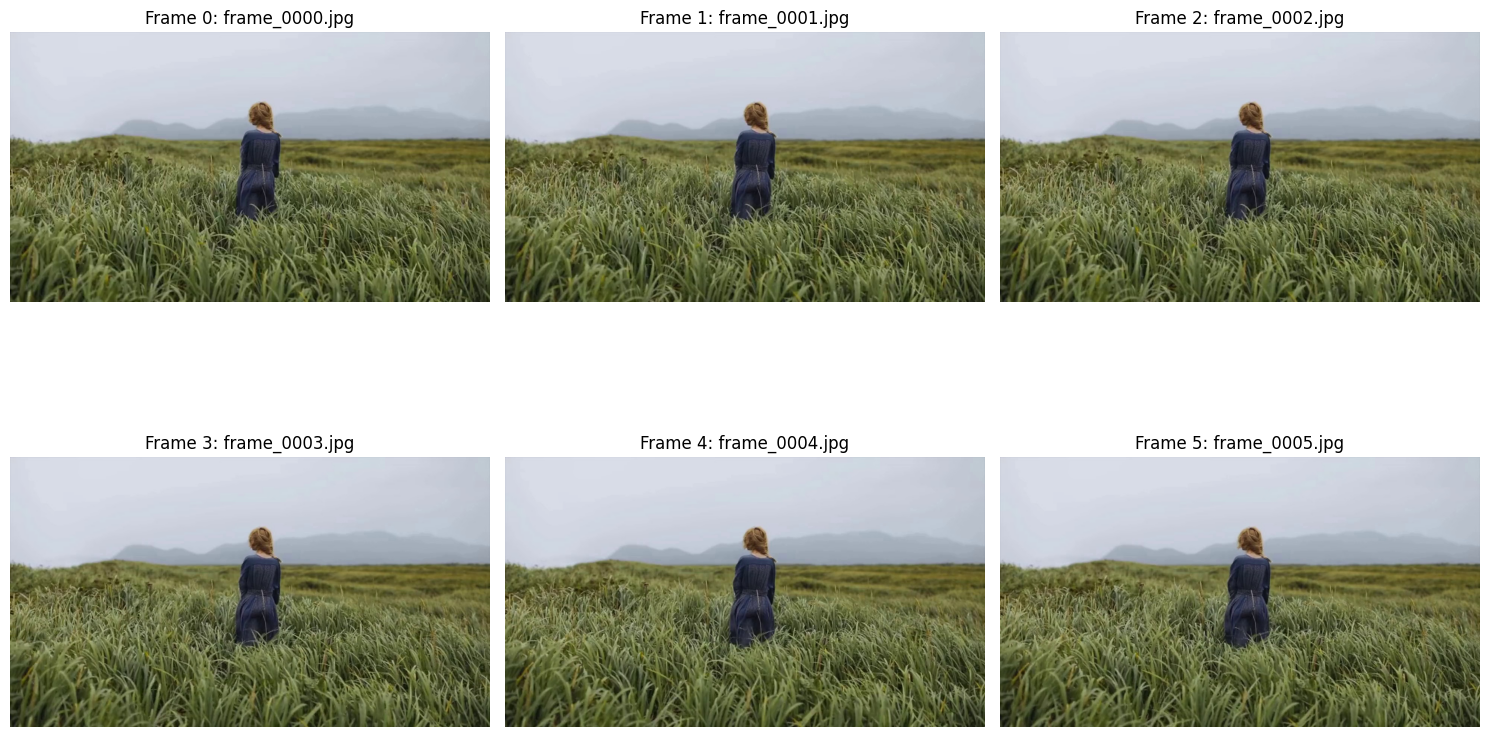

✓ Frame extraction test passed
  Extracted 195 frames
  Resolution: 1280x720

STEP 2: Camera Intrinsics Estimation
No chessboard patterns found. Using default intrinsics estimation...
✓ Using default camera intrinsics
  Focal length: fx=1536.0, fy=1536.0
  Principal point: (640.0, 360.0)
Camera Intrinsics Matrix (K):
[[1.536e+03 0.000e+00 6.400e+02]
 [0.000e+00 1.536e+03 3.600e+02]
 [0.000e+00 0.000e+00 1.000e+00]]

Camera Parameters:
  Focal length: fx=1536.00, fy=1536.00
  Principal point: cx=640.00, cy=360.00
  Field of view: 45.2° x 26.4°


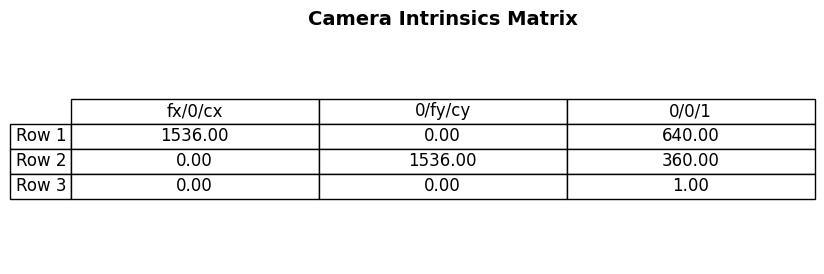

✓ Camera intrinsics test passed
  Focal lengths: fx=1536.0, fy=1536.0
  Principal point: (640.0, 360.0)
  Condition number: 1.89e+03

STEP 3: Depth Estimation


xFormers not available
xFormers not available
/home/jiabinshen/Documents/VideoDoodles/.conda/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


xFormers not available
xFormers not available
Using device: cpu
✓ Model loaded successfully: vits
Loading 195 frames...


Loading frames: 100%|██████████| 195/195 [00:01<00:00, 185.48it/s]


Frames shape: (195, 720, 1280, 3)
Estimating depth for 195 frames...
This may take a while for long videos...


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Complete workflow example
# Test with the provided video file

VIDEO_PATH = "4511004-uhd_3840_2160_24fps_rgb_src.mp4"

# Step 1: Extract frames
# For 4K video, resize to 1920x1080 for faster processing
print("=" * 60)
print("STEP 1: Frame Extraction")
print("=" * 60)
frame_count, fps, resolution = extract_frames(VIDEO_PATH, FRAMES_DIR, max_resolution=(1920, 1080))
visualize_frames(FRAMES_DIR, num_frames=6)
test_frame_extraction(FRAMES_DIR, frame_count, resolution)

# Step 2: Estimate camera intrinsics
print("\n" + "=" * 60)
print("STEP 2: Camera Intrinsics Estimation")
print("=" * 60)
K = estimate_camera_intrinsics(FRAMES_DIR, resolution)
visualize_camera_intrinsics(K, resolution)
test_camera_intrinsics(K, resolution)

# Step 3: Estimate depth
print("\n" + "=" * 60)
print("STEP 3: Depth Estimation")
print("=" * 60)
model_result = setup_video_depth_anything(encoder='vits')
if model_result is not None:
    model, device = model_result
    depth_maps, depth_range, depth_offset = estimate_depth_video(
        model, device, FRAMES_DIR, DEPTH_DIR, max_frames = 5
    )
    visualize_depth(FRAMES_DIR, DEPTH_DIR, frame_idx=0)
    test_depth_estimation(DEPTH_DIR, FRAMES_DIR, frame_count)
else:
    print("⚠ Skipping depth estimation - model not available")
    print("Creating dummy depth maps for testing...")
    # Create dummy depth maps for testing
    frame_files = sorted([f for f in os.listdir(FRAMES_DIR) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    depth_maps = []
    for i, frame_file in enumerate(frame_files):
        frame = cv2.imread(os.path.join(FRAMES_DIR, frame_file))
        dummy_depth = np.ones((frame.shape[0], frame.shape[1]), dtype=np.float32) * 5.0
        depth_path = os.path.join(DEPTH_DIR, f"depth_{i:04d}.npy")
        np.save(depth_path, dummy_depth)
        depth_maps.append(depth_path)

# Step 4: Interactive canvas placement
# Use display_scale=0.5 for 4K videos to show at half resolution for better performance
print("\n" + "=" * 60)
print("STEP 4: Interactive Canvas Placement")
print("=" * 60)
ui_controls, canvas_data = create_interactive_ui(FRAMES_DIR, DEPTH_DIR, K, resolution, display_scale=0.5)
display(ui_controls)

# After placing canvas, test it
if canvas_data['position_2d'] is not None:
    test_canvas_placement(canvas_data, depth_maps, K, resolution)
    export_canvas_data(canvas_data, CANVAS_DATA_FILE)
